In [1]:
#Script to study the type of interactions as calculated by Arpeggio
#@author: Henriette Capel
#@Date: 03-05-2022
#@Edited: Gemma Gordon January 2023

In [1]:
#Import modules
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import ast
#from ABDB import database as db
import re
from collections import Counter
from sklearn import metrics
import seaborn as sns
import random
from scipy.stats import sem
from statistics import mean
#%load_ext nb_black

In [32]:
#Constants
path_input = "/data/icarus/capel/data_arpeggio/output/"
general_types_list = ["clash","covalent","vdw_clash","vdw","proximal"]
residue_columns_list = ["residue_1", "residue_2"]
feature_list = ["hbond", "weak_hbond", "xbond", "ionic", "metal_complex", "aromatic", "hydrophobic", "carbonyl", "polar", "weak_polar"]

dict_cdr_positions_heavy = {"CDRH1": [27,38], 
                     "CDRH2": [56,65],
                     "CDRH3": [105,117]}

list_all_cdr_positions_heavy = []
for cdr_type in dict_cdr_positions_heavy.keys():
    min_position = dict_cdr_positions_heavy[cdr_type][0]
    max_position = dict_cdr_positions_heavy[cdr_type][1]
    cdrh_numbers = list(range(min_position, max_position+1))
    list_all_cdr_positions_heavy += cdrh_numbers
    
sns.set_style("darkgrid")

In [3]:
#Functions
def read_dataset(filename_ds):
    
    df = pd.read_csv(filename_ds, converters={i: str for i in range(100)})
    
    for colname in df.columns.values.tolist():
        try:
            df[colname] = [ast.literal_eval(d) for d in df[colname]]
        except:
            pass

    return df

def determine_number_general_types_in_dataset(df_ds, residue_columns_list, general_types_list, heavy_chain_only=False):
    interested_columns_list = residue_columns_list + general_types_list
    dict_general_types_sum = {}
    for general_type in general_types_list:
        dict_general_types_sum[general_type] = 0

    for index, row in df_ds.iterrows():
        pdb, ag_chain, ab_chain = subtract_complex_info(row)
        
        if len(ab_chain)==2: #full length antibody
            path = f"{path_input}/full_length/{pdb}_{ag_chain}_{ab_chain}_residue_interactions.csv"
        else:
            path = f"{path_input}/single_domain/{pdb}_{ag_chain}_{ab_chain}_residue_interactions.csv"
        try:
            df_temp = pd.read_csv(path)
            df_temp = df_temp[interested_columns_list]
            if heavy_chain_only:
                df_temp[['chain_res2', 'position_res2']] = df_temp['residue_2'].str.split('/', expand=True)
                df_temp = df_temp[df_temp["chain_res2"]==ab_chain[0]]
            for general_type in general_types_list:
                dict_general_types_sum[general_type] += df_temp[general_type].sum()
                
        except FileNotFoundError:
            print(f"File not found: {pdb}_{ag_chain}_{ab_chain}")
    return dict_general_types_sum

def mutual_info_general_types(df_ds, residue_columns_list, general_types_list, heavy_chain_only=False):
    list_types_info = []
    for index, row in df_ds.iterrows():
        pdb, ag_chain, ab_chain = subtract_complex_info(row)
        
        if len(ab_chain)==2: #full length antibody
            path = f"{path_input}/full_length/{pdb}_{ag_chain}_{ab_chain}_atom_interactions.csv"
        else:
            path = f"{path_input}/single_domain/{pdb}_{ag_chain}_{ab_chain}_atom_interactions.csv"
        try:
            df_temp = pd.read_csv(path)
            if heavy_chain_only:
                df_temp[['chain_res2', 'position_res2', 'atom_res2']] = df_temp['atom_end'].str.split('/', expand=True)
                df_temp = df_temp[df_temp["chain_res2"]==ab_chain[0]]
            for index, row in df_temp.iterrows():
                if row["clash"] != 0:
                    type_value = 0
                elif row["covalent"] != 0:
                    type_value = 1
                elif row["vdw_clash"] != 0:
                    type_value = 2
                elif row["vdw"] != 0:
                    type_value = 3
                else: #proximal
                    type_value = 4
                list_types_info.append(type_value)
        except FileNotFoundError:
            print(f"File not found: {pdb}_{ag_chain}_{ab_chain}")
    return list_types_info

def determine_ab_ag_column(df, ab_chain, ag_chain):
    #this function determines which of the "atom_*" rows in the output of arpeggio dataframes belongs to the antigen and which to the antibody
    #Besides, the function checks if indeed one column only contains information of one of these proteins
    df[['chain_res1', 'position_res1', 'atom_res1']] = df['atom_bgn'].str.split('/', expand=True)
    df[['chain_res2', 'position_res2', 'atom_res2']] = df['atom_end'].str.split('/', expand=True)

    #Make list containing all chains seen in column
    list_1 = list(set(df['chain_res1'].tolist())) 
    list_2 = list(set(df['chain_res2'].tolist()))
    
    if len(list_1) == len(list_2) == 1: #should only be 2 if it is the antibody and we are considering the full length antibody
        #Dealing with single domain antibody and no mistakes
        if list_1[0] == ab_chain and list_2[0] == ag_chain:
            df=df.rename(columns = {'atom_bgn':'antibody', 'atom_end':'antigen'}) #Change in original dataframe
        else:
            df=df.rename(columns = {'atom_bgn':'antigen', 'atom_end':'antibody'})
    elif len(list_1) == 2 and len(list_2) == 1:
        df=df.rename(columns = {'atom_bgn':'antibody', 'atom_end':'antigen'})
    elif len(list_1) == 1 and len(list_2) == 2:
        df=df.rename(columns = {'atom_bgn':'antigen', 'atom_end':'antibody'})
    else:
        print(f"WARNING: antigen and antibody columns are mixed: chain_bgn: {set_1}, chain_end: {set_2}")
        
    return df

def determine_feature_interactions(df_ds, residue_columns_list, general_types_list, feature_list, protein= "antibody", heavy_chain_only=False):
    #Determines for each atom-atom interaction in the dataset what kind of interaction is established and stores this information per position. 
    #Note store in a list such that later possible to count how often each interaction is established
    #Note store both interactions in the combined way (meaning that if one atom-atom complex forms 2 interactions they are stored as A/B) and the individual way (meaning that both A and B are stored seperately)
    #Note for the individual way the total amount of stored interactions is bigger than the number of atom-atom complexes formed
        
    dict_position_combined_interactions = {}
    dict_position_individual_interactions = {}
    dict_complex_list_interactions = {} 
    
    interested_columns = ["antigen", "antibody", "covalent", "vdw"]+feature_list

    #iterate through the dataset, open for every complex the arpeggio output, read the data and store all types of "feature" interactions seen between all atom-atom complexes in the dataset
    for index, row in df_ds.iterrows():
        pdb, ag_chain, ab_chain = subtract_complex_info(row)
        complex_epitope = row["epitope_MWV_dict"]
        complex_paratope = row["paratope_MWV_dict"]
        complex_id = f"{pdb}_{ag_chain}_{ab_chain}"
        
        #Find path to output arpeggio
        if len(ab_chain)==2: #full length antibody
            path = f"{path_input}/full_length/{pdb}_{ag_chain}_{ab_chain}_atom_interactions.csv"
        else:
            path = f"{path_input}/single_domain/{pdb}_{ag_chain}_{ab_chain}_atom_interactions.csv"
            
        #open output arpeggio as pandas dataframe
        try:
            df_temp = pd.read_csv(path)
            
            #Assign "antigen" and "antibody" to the correct column containing the atoms of these proteins
            df_temp = determine_ab_ag_column(df_temp, ab_chain, ag_chain)
            
            #remove the heteroatoms from the dataframe such that those interactions will not be considered 
            df_temp = remove_heteroatoms(df_temp, complex_epitope, complex_paratope, ab_chain)
            df_temp = df_temp.drop(['chain_res1', 'position_res1', 'atom_res1', 'chain_res2', 'position_res2', 'atom_res2'], axis=1)
            
            if heavy_chain_only: #Select only atom interactions of the heavy chain
                df_temp[['chain_ab', 'position_ab', 'atom_ab']] = df_temp['antibody'].str.split('/', expand=True)
                df_temp = df_temp[df_temp["chain_ab"]==ab_chain[0]]
                df_temp = df_temp.drop(['chain_ab', 'position_ab', 'atom_ab'], axis=1) #Drop columns again to prevent a position 1 is counted as interaction
                df_temp = df_temp.reset_index() #reset index; necesairy to find the correct position later on
                if df_temp.empty:
                    print(f"WARNING: this heavy chain only dataframe is empty: {pdb}_{ag_chain}_{ab_chain}")
                    break
            
            df_temp = df_temp[interested_columns]
            list_of_list_interaction_temp = df_temp.apply(lambda row: row[row == 1].index, axis=1).to_list()
            
            #In order to save the intreactions per position, determine in which protein ('antibody' or 'antigen') you are interested. 
            #If you want to study the CDR and framework residues this should be 'antibody' if you want to study the epitope this should be "antibody".
            if protein == "antibody":
                df_temp[['chain', 'position', 'atom']] = df_temp['antibody'].str.split('/', expand=True) 
            elif protein == "antigen":
                df_temp[['chain', 'position', 'atom']] = df_temp['antigen'].str.split('/', expand=True)                 
            else: 
                print(f"WARNING: input {protein} is not possible")
            df_temp = df_temp.reset_index()
        
            #Loop over all interatomic interactions and store the interaction type
            dict_complex_position_info = {}
            for i in range(len(list_of_list_interaction_temp)):           
                if len(list_of_list_interaction_temp[i]) >= 1: #Interaction between atoms found
                    interaction_combi = "/".join(list_of_list_interaction_temp[i]) #Note not combine by "_" because already used in naming of individual types
                    position = str(df_temp.loc[i]["position"])
                    
                    #Save the combined version
                    try:
                        dict_position_combined_interactions[position].append(interaction_combi)
                    except KeyError: #position not seen before
                        dict_position_combined_interactions[position] = [interaction_combi]
                        
                    #Save the individual version
                    try:
                        dict_position_individual_interactions[position] += list_of_list_interaction_temp[i].tolist() #store all elements in list_of_list_interaction_temp[i] seperately to the list_combinat
                    except KeyError: #Position/complex not seen before
                        # print(f"Position not seen before: {position}") 
                        dict_position_individual_interactions[position] = list_of_list_interaction_temp[i].tolist()
                        
                    #Save per complex info
                    try:
                        dict_complex_position_info[position] += list_of_list_interaction_temp[i].tolist()
                    except KeyError:
                        dict_complex_position_info[position] = list_of_list_interaction_temp[i].tolist()
            
            dict_complex_list_interactions[complex_id] = dict_complex_position_info #save per complex per position interaction information
        except FileNotFoundError:
            print(f"File not found: {pdb}_{ag_chain}_{ab_chain}")
    

    return dict_position_combined_interactions, dict_position_individual_interactions, dict_complex_list_interactions

def remove_heteroatoms(df, epitope_dict, paratope_dict, ab_chain):
    #This function takes a dataframe containing the interatomic information as input, and uses the epitope and paratope dictionaries to only select the positions with non hetero atoms
    #Format for single domain: epitope_dict: {position: amino_acid}, paratope_dict: {position: amino_acid}
    #Format for full length: epitope_dict: {heavy chain: {position: amino_acid}, light_chain:{...}, both_chains:{...}}, paratope_dict: {heavy_chain: {position: amino_acid}, light_chain: {...}}
    #position can be "112" or "112B" for example. This is similar as stored in the input dataframe
    #The columns containing the epitope and paratope positions are called "position_res1" and "position_res2" respectively.
    
    if len(ab_chain)==2:
        heavy_chain = ab_chain[0]
        light_chain = ab_chain[1]
        epitope_residues_list = epitope_dict[ab_chain]
        paratope_residues_list_heavy = paratope_dict[heavy_chain]
        paratope_residues_list_light = paratope_dict[light_chain]
        df_heavy = df[df["chain_res2"]== heavy_chain]
        df_light = df[df["chain_res2"]== light_chain]
        
        df_heavy = remove_rows_interatomic(df_heavy, epitope_residues_list, paratope_residues_list_heavy)
        df_light = remove_rows_interatomic(df_light, epitope_residues_list, paratope_residues_list_light)
        df = pd.concat([df_heavy, df_light])
    else:
        epitope_residues_list = epitope_dict.keys()
        paratope_residues_list = paratope_dict.keys()
        df = remove_rows_interatomic(df, epitope_residues_list, paratope_residues_list)
    
    return df

def remove_rows_interatomic(df, epitope_residues_list, paratope_residues_list):
    #Function to remove positions that are not listed
    
    #Make sure epitope and paratope residues are strings (needed to find 112A)
    epitope_residues_list = [str(x) for x in epitope_residues_list]
    paratope_residues_list = [str(x) for x in paratope_residues_list]
    
    df = df[df['position_res1'].isin(epitope_residues_list)]
    df = df[df['position_res2'].isin(paratope_residues_list)]
    df = df.reset_index()

    return df


def transform_list_interactions_to_dict_occuring(dict_position_interaction, list_interested_positions = False, subsample = False):
    #Combines the values of the dictionaries to one list and counts how often every interaction is established.
    #If a list of interested positions is given, only the positions listed are considered. 
    if list_interested_positions != False: #Make a new dictionary with only the interested positions, Note need "!= False" because otherwise if "list_interested_positions" it will see it as not present
        dict_position_interaction = create_dict_interested_positions_interactions(dict_position_interaction, list_interested_positions)
    total_list = create_list_of_all_interactions(dict_position_interaction)
    
    #Perform subsampling here
    if subsample == True:
        subsample_info = subsample_mean_standard_dev(total_list, repetitions = 1000)
        return subsample_info
    else:
        dict_interaction_occuring = create_dict_occurence_of_list(total_list)
        return dict_interaction_occuring

def subsample_mean_standard_dev(total_list, repetitions = 1000):
    #this function takes 10% of the total list 1000 times and determines the mean and standard error.
    #the output dictionary has interaction types as keys and values are lists of length 2 in which first position is mean and second is standard error. 
    num_select = int(len(total_list)/10)
    
    #set up dictionary in which you will store counts and one summarising the dict_counts
    dict_counts = {}
    dict_summary = {}

    #Subsample multiple times
    for i in range(repetitions):
        sampled_list = random.sample(total_list, num_select)
        dict_interaction_occuring = create_dict_occurence_of_list(sampled_list)
        
        #Save the observed counts as percentages
        for interaction_type in dict_interaction_occuring.keys():
            try:
                dict_counts[interaction_type] += [dict_interaction_occuring[interaction_type]/sum(dict_interaction_occuring.values())*100]
            except KeyError: #position not seen before
                dict_counts[interaction_type] = [dict_interaction_occuring[interaction_type]/sum(dict_interaction_occuring.values())*100]
    
    #determine mean and standard error for each interaction type
    print("warning: testing with standard deviation")
    for interaction_type in dict_counts.keys():
        list_info = dict_counts[interaction_type]
        mean_value = mean(list_info)
        std_error = sem(list_info)
        stand_dev = np.std(list_info)
        dict_summary[interaction_type] = [mean_value, stand_dev]
    
    return dict_summary


def create_list_of_all_interactions(dict_position_interaction):
    total_list = []
    for list_interactions in dict_position_interaction.values():
        total_list += list_interactions 
    return total_list

def create_dict_occurence_of_list(list_info):
    return dict(Counter(list_info))

def create_dict_interested_positions_interactions(dict_positions_interactions, list_interested_positions):
    #This function selects only the keys (positions that are of interest, and stores this in a seperate dictionary.
    #Note that "112" and "112A" are stored seperately and should now be combined
    
    dict_selected_positions_interactions = {}
    
    list_positions_all = list(dict_positions_interactions.keys())
    for position in list_positions_all:
        match = re.match(r"([0-9]+)([a-z]+)", position, re.I) #Note position can be "112B". So subtract the number from the number and insertion combination
        if match:
            items = match.groups()
            pos_num = int(items[0])
        else:
            pos_num = int(position)

        #Check if position in list of interested residues
        if pos_num in list_interested_positions:
            try:
                dict_selected_positions_interactions[pos_num] += dict_positions_interactions[position] #If already excist (for example when both "112" and "112A" present)
            except KeyError:
                dict_selected_positions_interactions[pos_num] = dict_positions_interactions[position]
    return dict_selected_positions_interactions
            
def create_input_mutual_info_score(list_info_1, list_info_2):
    #this function creates a list of integers which correspond to the types if interactions (and combinations) occuring.
    #All interaction types and combinations present in the two lists are combined to assign an interger to every type.
    
    #make dictionary of all different types assigned to number
    combined_set_types = set(list_info_1) | set(list_info_2)
    number = 0
    dict_assign_type_number = {}
    for interaction_type in combined_set_types:
        dict_assign_type_number[interaction_type] = number
        number += 1
        
    #Store the interaction types as numbers
    list_info_number_1 = transform_interaction_type_to_number(list_info_1, dict_assign_type_number)
    list_info_number_2 = transform_interaction_type_to_number(list_info_2, dict_assign_type_number)
    
    return list_info_number_1, list_info_number_2
        
def transform_interaction_type_to_number(list_interaction_types, dict_assign_interaction_types_to_number):
    list_info_number = []
    for element in list_interaction_types:
        list_info_number.append(dict_assign_interaction_types_to_number[element])
    return list_info_number

def subtract_complex_info(df_row):
    pdb = df_row["pdb"]
    ag_chain = df_row["antigen_chain"]
    ab_chain = df_row["antibody_chain"]
    return pdb, ag_chain, ab_chain

def determine_mutual_info_score(list_info_1, list_info_2):
    #Calculates the adjusted mutual information score between two two classes. Takes as input the information list per class.
    list_class_1 = [0]*len(list_info_1)
    list_class_2 = [1]*len(list_info_2)
    
    #Combine to make input for mutual information score function
    list_classes = list_class_1 + list_class_2
    list_info = list_info_1 + list_info_2
    
    score = metrics.adjusted_mutual_info_score(list_info, list_classes)
    return score

def make_histogram(dict_info, title, color): 
    xnames = list(dict_info.keys())
    yvalues = list(dict_info.values())
    
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    rects1 = ax.bar(xnames, make_percentages(yvalues), color = color)
    plt.ylabel("Percentage of interactions")
    plt.xticks(rotation=90)
    plt.title(f"{title}")
    plt.show()
    
    
def make_hist_2db(dict_info_1, dict_info_2, ab_type1, ab_type2, color1, color2, title):
    #Makes histogram to compare the information of two different datasets
    width = 0.45
    
    dict_info_1 = {key: value for key, value in sorted(dict_info_1.items())}
    dict_info_2 = {key: value for key, value in sorted(dict_info_2.items())}
    
    xnames1 = list(dict_info_1.keys())
    yvalues1 = list(dict_info_1.values())
    yvalues1_norm = make_percentages(yvalues1)
    
    xnames2 = list(dict_info_2.keys())
    yvalues2 = list(dict_info_2.values())
    yvalues2_norm = make_percentages(yvalues2)
    
    fig, ax = plt.subplots()
    rects1 = ax.bar(xnames1, yvalues1_norm, - width, align='edge', color = color1, label = ab_type1)
    rects2 = ax.bar(xnames2, yvalues2_norm, +width, align='edge', color = color2, label = ab_type2)
    plt.ylabel("Percentage of interaction occuring")
    plt.xticks(rotation=90)
    plt.legend()
    plt.title(f"{title}")
    plt.show()
    
    
def make_hist_3db(dict_info_1, dict_info_2, dict_info_3, ab_types: list, colors: list, title: str):
    #Makes histogram to compare the information of two different datasets
    width = 0.3
    
    dict_info_1 = {key: value for key, value in sorted(dict_info_1.items())}
    df_info = pd.DataFrame([dict_info_1, dict_info_2, dict_info_3]).T
    df_info.columns = ab_types
    df_info = df_info.dropna(how='all')
    print(df_info)
    
    #Make percentages
    for ab_type in ab_types:
        df_info[ab_type] = (df_info[ab_type] / df_info[ab_type].sum()) * 100
    
    color_dict = {}
    for i in range(len(ab_types)):
        color_dict[ab_types[i]] =  colors[i]
        
    ax = df_info.plot.bar(rot=0, color=color_dict)
    
    ax.set_ylim([0, 50])
    plt.ylabel("Percentage of observed interactions")
    plt.xticks(rotation=90)
    plt.legend()
    # plt.title(f"{title}")
    plt.show()
    # plt.savefig(f'interactions_{title}.png', bbox_inches='tight')
    
def dict_to_df_seperate_list(dict_info, type_ds):
    dict_info = pd.DataFrame(dict_info).T
    dict_info.columns = [f"{type_ds}_mean", f"{type_ds}_std_err"]
    return dict_info

def make_hist_3db_subsample(dict_info_1, dict_info_2, dict_info_3, ab_types: list, colors: list, title: str):
    #Makes histogram to compare the information of two different datasets
    width = 0.3
    
    #set up dataframe containing all information
    dict_info_1 = dict_to_df_seperate_list(dict_info_1, ab_types[0])
    dict_info_2 = dict_to_df_seperate_list(dict_info_2, ab_types[1])
    dict_info_3 = dict_to_df_seperate_list(dict_info_3, ab_types[2])
    
    df_info = pd.concat([dict_info_1, dict_info_2, dict_info_3], axis = 1)
    df_info = df_info.dropna(how='all')
    df_info = df_info.sort_index() #sort index such that interaction types in same order
    
    columns = list(df_info.columns)
    
    fig, ax = plt.subplots()
    ind = np.arange(df_info.shape[0]) 
    rects1 = ax.bar(ind - width, df_info[columns[0]], width, yerr=df_info[columns[1]], label= ab_types[0], color= colors[0], ecolor='black', capsize=6)
    rects2 = ax.bar(ind, df_info[columns[2]], width, yerr=df_info[columns[3]], label= ab_types[1], color= colors[1], ecolor='black', capsize=6)
    rects3 = ax.bar(ind+ width, df_info[columns[4]], width, yerr=df_info[columns[5]], label= ab_types[2], color= colors[2], ecolor='black', capsize=6)

    ax.set_ylim([0, 50])
    plt.xticks(ind, list(df_info.index), fontsize = 15, rotation = 90)
    # ax.set_xticklabels(list(df_info.index), rotation=90, fontsize=15)
    plt.ylabel("Percentage of observed interactions", fontsize=15)
    plt.legend(loc = "upper right", fontsize = 15)
    plt.gcf().set_size_inches(10, 6) #Set sizes plot
    # plt.title(f"{title}")
    # plt.show()
    plt.savefig(f'interactions_subsample_{title}_bigfont.png', bbox_inches='tight')
    
def make_percentages(yvalues):
    yvalues_norm = [i/sum(yvalues)*100 for i in yvalues]
    return yvalues_norm 

def select_complex_info(df_row):
    #this function select the complex info (pdb, antigen chain, antibody chain). the input should be a row of a dataframe
    pdb = df_row["pdb"]
    ag_chain = df_row["antigen_chain"]
    ab_chain = df_row["antibody_chain"]
    
    return pdb, ag_chain, ab_chain

#Cluster
def create_input_for_cluster(df_ds, residue_columns_list, general_types_list, feature_list, heavy_chain_only=False):
    #this function determines for every complex in the dataset how often each interaction is seen. The output is a dataframe
    
    #interactions of interest
    interactions_interest = ["vdw", "covalent"] + feature_list
    #Set up the dictionary
    dict_ouput= {"complex": []}
    for feature_interaction in interactions_interest:
        dict_ouput[feature_interaction] = []
    
    for index, row in df_ds.iterrows():
        #Save general information of complex under consideration
        pdb, ag_chain, ab_chain = select_complex_info(row)
        dict_ouput["complex"].append(f"{pdb}_{ag_chain}_{ab_chain}")
        
        #Determine which interactions are present, count how often each interaction is seen, and make it a fraction
        df_temp = df_ds[(df_ds["pdb"] == pdb)&(df_ds["antigen_chain"] ==ag_chain)&(df_ds["antibody_chain"] ==ab_chain)] #select this row in the form of a dataframe
       
        #run the function "determine_feature_interactions" on this row only to select the interaction information per complex
        dict_pos_comb_interactions, dict_pos_ind_interactions, dict_complex_info = determine_feature_interactions(df_temp, residue_columns_list, general_types_list, feature_list, "antibody")
        dict_pos_ind_interactions_occuring = transform_list_interactions_to_dict_occuring(dict_pos_ind_interactions)
        dict_pos_ind_inter_occ_frac = {k: v / total for total in (sum(dict_pos_ind_interactions_occuring.values()),) for k, v in dict_pos_ind_interactions_occuring.items()}
        
        #Store as a 
        for feature_interaction in interactions_interest:
            try: 
                dict_ouput[feature_interaction].append(dict_pos_ind_inter_occ_frac[feature_interaction])
            except KeyError: #This interaction is not seen in this complex
                dict_ouput[feature_interaction].append(0.0) #Should append 0.0 because otherwise the link between complex id and information will be lost
    
    df = pd.DataFrame.from_dict(dict_ouput)
    return df
        
    
def df_clustermap_twotypes_info(df_nb, df_fv):
    df_nb = df_nb.copy(deep=True) #Needed to prevent changing original dataframes
    df_fv = df_fv.copy(deep=True)
    df_nb['antibody_type'] = "single_domain"
    df_fv['antibody_type'] = "full_length"
    df_concat = pd.concat([df_nb, df_fv])
    
    return df_concat

def plot_cluster(df_cluster_info: pd.DataFrame, two_types: bool = False):
    df_cluster_info = df_cluster_info.set_index('complex')
    #sns.light_palette("seagreen", as_cmap=True)
    
    if two_types == True:
        antibody_type = df_cluster_info.pop("antibody_type")
        lut = dict(zip(antibody_type.unique(), ['royalblue', 'lightcoral']))
        row_colors = antibody_type.map(lut)
        g = sns.clustermap(df_cluster_info, row_colors=row_colors)
    else:
        g = sns.clustermap(df_cluster_info)

#Boxplot
def create_dataframe_boxplot_one_ds(dict_complex_position_interaction, dataset_id, list_interested_positions=False):
    #This function takes as input a dictionary containing per complex_id a dictionary with the position as key and a list of the interactions as value.
    #For each complex_id dictionary "transform_list_interactions_to_dict_occuring" is used to determine for the interesting positions how often each bond occurs. 
    #Output is a dataframe containing the complex_id, dataset, bond_type and how often occuring.
    #Note: bond type is one column so each complex occurs X times in the dataframe where X is the nummer of interaction types considered
    column_names = ["complex_id", "set", "bond_type", "occurence"]
    df_new = pd.DataFrame(columns = column_names)
    index = 0
    
    for complex_info in dict_complex_position_interaction.keys():
        #count occurence each interaction type for all positions of interest
        dict_interaction_occurence = transform_list_interactions_to_dict_occuring(dict_complex_position_interaction[complex_info], list_interested_positions)
        
        #Make percentage per complex instead of occurence 
        dict_interaction_occurence = {k: v / total * 100 for total in (sum(dict_interaction_occurence.values()),) for k, v in dict_interaction_occurence.items()}
        
        for interaction_type in dict_interaction_occurence.keys():
            d = {"complex_id": complex_info, "set": dataset_id, "bond_type": interaction_type, "occurence": dict_interaction_occurence[interaction_type]} 
            df_line = pd.DataFrame(d, index=[index])
            df_new = pd.concat([df_new, df_line])
            index +=1

    return df_new

def make_boxplot(df_all_sets, residues =  "all"):
    ax = sns.boxplot(x='bond_type', y='occurence', hue='set', data=df_all_sets, palette= {"sdAb": "mediumblue", "flAb": "red", "flAb_heavy":"firebrick"}, order = ['aromatic','carbonyl','hbond','hydrophobic','ionic','polar','vdw','weak_hbond','weak_polar', 'covalent'])
    plt.setp(ax.get_xticklabels(), rotation=90, fontsize=12)  
    plt.setp(ax.get_yticklabels(), fontsize=12)  
    ax.set_xlabel("", fontsize=6)
    ax.set_ylabel("Percentage observed interactions per complex", fontsize=20)
    # plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.legend(loc=1, fontsize = 20)
    plt.gcf().set_size_inches(10, 5) #Set sizes plot
    # plt.savefig(f'boxplot_{residues}.png', bbox_inches='tight')
    plt.show()
    
#Interaction types per amino acid
def determine_type_interactions_per_aa_type(df_ds, aa_type, residue_columns_list, general_types_list, feature_list, protein="antibody", is_full_length=False):
    #This function stores the epitope residues as determined by arepggio and studies the type of interactions it is making. 
    #Note: the input for this function should be the epitope which has the same format as my annotations. So for every epitope position the amino acid type is known.
    total_dict_interactions = {}
    for interaction_type in feature_list:
        total_dict_interactions[interaction_type] = 0
    
    for index, row in df_ds.iterrows():
        #select information form the complex in this row
        pdb, ag_chain, ab_chain = select_complex_info(row)
        dict_epi_pos_aa = row["epitope_MWV_dict"]
        
        #For full length antibodies the epitope_MWV_dict is stored as: {"heavy_chain": {}, "light_chain": {}, "both_chains": {}}
        if len(ab_chain)==2:
            if is_full_length:
                dict_epi_pos_aa = row["epitope_MWV_dict"][ab_chain[0]]
            else:
                dict_epi_pos_aa = row["epitope_MWV_dict"][ab_chain]
        
        #Determine the type of interactions per position for every complex, select only the psotions of interest and count how often each interaction type is present
        list_selected_positions_str = determine_positions_aa_type(dict_epi_pos_aa, aa_type)
        list_selected_positions = []
        for position in list_selected_positions_str:
            match = re.match(r"([0-9]+)([a-z]+)", position, re.I) #Note position can be "112B". So subtract the number from the number and insertion combination
            if match:
                items = match.groups()
                pos_num = int(items[0])
            else:
                pos_num = int(position)
            list_selected_positions.append(pos_num)
        

        df_temp = df_ds[(df_ds["pdb"] == pdb)&(df_ds["antigen_chain"] ==ag_chain)&(df_ds["antibody_chain"] ==ab_chain)] #select this row in the form of a dataframe
        dict_pos_comb_interactions, dict_pos_ind_interactions, dict_complex_info = determine_feature_interactions(df_temp, residue_columns_list, general_types_list, feature_list, protein, is_full_length)
        dict_interaction_occuring = transform_list_interactions_to_dict_occuring(dict_pos_ind_interactions, list_selected_positions)
        #Save in the "total_dict_interactions" dictionary to get info over whole dataset.
        for interaction_type in feature_list:
            try:
                total_dict_interactions[interaction_type] += dict_interaction_occuring[interaction_type]
            except KeyError: #this interaction is not seen in this complex
                pass #Do not need to do anything
            
    return total_dict_interactions
        
        
def determine_positions_aa_type(dict_epitope_position_aa: dict, aa_type: str):
    #this function makes a list containing the positions of the epitope that have a certain amino acid type
    list_positions = []
    for position in dict_epitope_position_aa.keys():
        if dict_epitope_position_aa[position] == aa_type:
            list_positions.append(position)
    return list_positions
            

In [33]:
#Single domain
ds_name_nb = "Dataset_nb_filtered.csv"
df_nb = read_dataset(ds_name_nb)

dict_general_types_sum_nb = determine_number_general_types_in_dataset(df_nb, residue_columns_list, general_types_list)
print(dict_general_types_sum_nb)

In [35]:
#full length
ds_name_fv = "Dataset_fv_filtered.csv"
df_fv = read_dataset(ds_name_fv)

# dict_general_types_sum_fv = determine_number_general_types_in_dataset(df_fv, residue_columns_list, general_types_list)
# print(dict_general_types_sum_fv)

# #heavy chain only
# dict_general_types_sum_heavy_fv = determine_number_general_types_in_dataset(df_fv, residue_columns_list, general_types_list, heavy_chain_only=True)
# print(dict_general_types_sum_heavy_fv)

In [7]:
#Determine mutual information score
list_types_info_nb  = mutual_info_general_types(df_nb, residue_columns_list, general_types_list)
list_types_info_fv  = mutual_info_general_types(df_fv, residue_columns_list, general_types_list)
mi_score_general_types = determine_mutual_info_score(list_types_info_nb, list_types_info_fv)
print(mi_score_general_types)

File not found: 5k9q_R_XY
File not found: 4xwo_N_QR
0.00010527693838658983


<IPython.core.display.Javascript object>

In [8]:
#Determine mutual information score heavy chain only
list_types_info_nb  = mutual_info_general_types(df_nb, residue_columns_list, general_types_list)
list_types_info_heavy_fv  = mutual_info_general_types(df_fv, residue_columns_list, general_types_list, heavy_chain_only=True)
mi_score_general_types_heavy = determine_mutual_info_score(list_types_info_nb, list_types_info_heavy_fv)
print(mi_score_general_types_heavy)

File not found: 5k9q_R_XY
File not found: 4xwo_N_QR
0.00011839241567638828


<IPython.core.display.Javascript object>

In [9]:
#### Study the types of "feature" interactions

<IPython.core.display.Javascript object>

In [36]:
#Single domain
dict_position_combined_interactions_nb, dict_position_individual_interactions_nb, dict_complex_info_nb = determine_feature_interactions(df_nb, residue_columns_list, general_types_list, feature_list, "antibody")

File not found: 7qiv_B_C
File not found: 6fe4_A_F
File not found: 5l21_A_B
File not found: 7a17_A_B
File not found: 6h7o_A_C
File not found: 5ja9_C_A
File not found: 7aqy_A_D
File not found: 4u3x_B_A
File not found: 5y7z_A_C
File not found: 5fuc_A_V
File not found: 7t5f_A_C
File not found: 7t5f_A_B
File not found: 2p42_A_B
File not found: 7n0r_A_C
File not found: 4ios_A_E
File not found: 5lwf_A_C
File not found: 3k74_A_B
File not found: 7oau_A_B
File not found: 7dv4_A_B
File not found: 4w2q_B_A
File not found: 4s10_C_A
File not found: 6hjy_A_F
File not found: 5m2m_A_F
File not found: 2x89_D_A
File not found: 4nc1_A_C
File not found: 4nc1_A_E
File not found: 7m1h_A_B
File not found: 7m1h_A_C
File not found: 7m1h_A_D
File not found: 7m1h_A_E
File not found: 7m1h_A_F
File not found: 7m1h_A_G
File not found: 6z2m_A_D
File not found: 4orz_B_C
File not found: 5ovw_A_H
File not found: 5m14_A_C
File not found: 5usf_A_D
File not found: 5ip4_D_B
File not found: 5f93_A_C
File not found: 6gkd_A_B


In [11]:
#Full length
dict_position_combined_interactions_fv, dict_position_individual_interactions_fv, dict_complex_info_fv = determine_feature_interactions(df_fv, residue_columns_list, general_types_list, feature_list, "antibody")


File not found: 5k9q_R_XY
File not found: 4xwo_N_QR


<IPython.core.display.Javascript object>

In [12]:
#Full length heavy only
dict_position_combined_interactions_heavy_fv, dict_position_individual_interactions_heavy_fv, dict_complex_info_heavy_fv = determine_feature_interactions(df_fv, residue_columns_list, general_types_list, feature_list, "antibody", heavy_chain_only=True)

File not found: 5k9q_R_XY


<IPython.core.display.Javascript object>

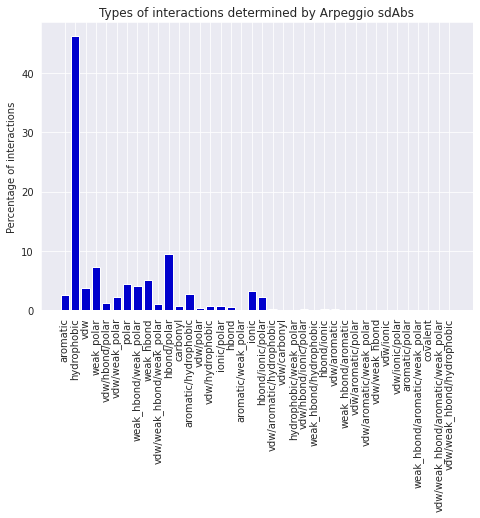

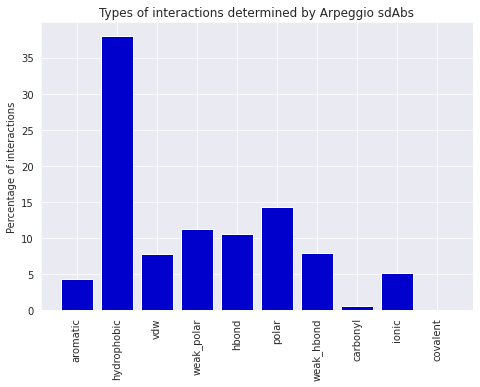

<IPython.core.display.Javascript object>

In [13]:
#Single domain 
make_histogram(transform_list_interactions_to_dict_occuring(dict_position_combined_interactions_nb), "Types of interactions determined by Arpeggio sdAbs", "mediumblue")
make_histogram(transform_list_interactions_to_dict_occuring(dict_position_individual_interactions_nb), "Types of interactions determined by Arpeggio sdAbs", "mediumblue")

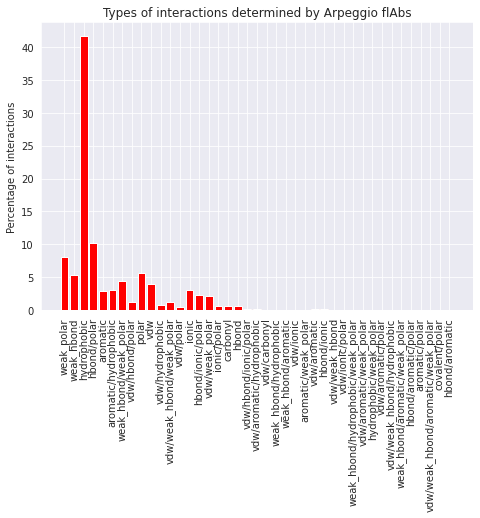

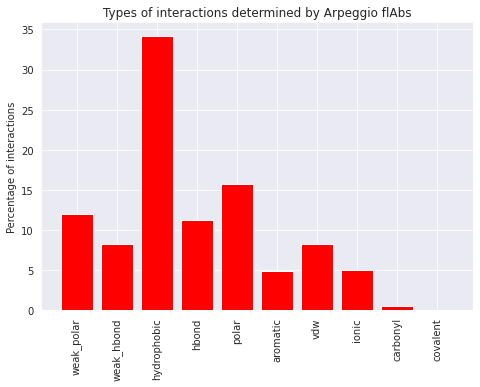

<IPython.core.display.Javascript object>

In [14]:
#Full length
make_histogram(transform_list_interactions_to_dict_occuring(dict_position_combined_interactions_fv), "Types of interactions determined by Arpeggio flAbs", "red")
make_histogram(transform_list_interactions_to_dict_occuring(dict_position_individual_interactions_fv), "Types of interactions determined by Arpeggio flAbs", "red")

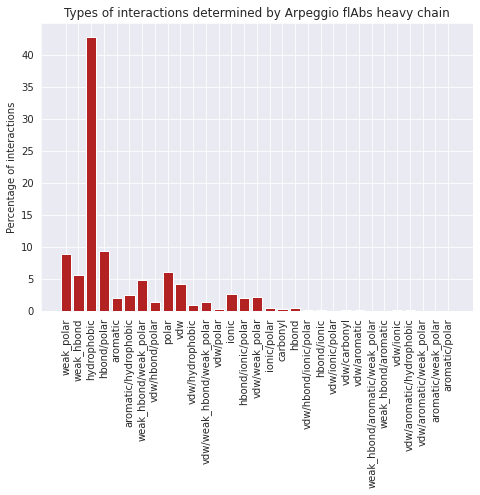

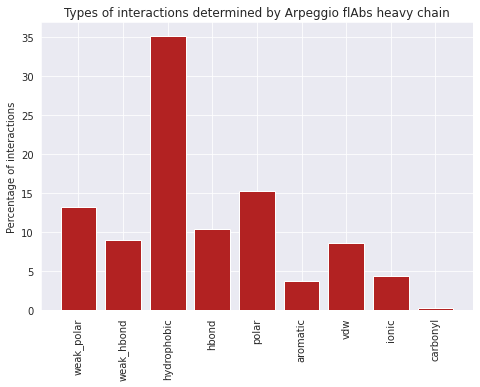

<IPython.core.display.Javascript object>

In [15]:
#Full length heavy only
make_histogram(transform_list_interactions_to_dict_occuring(dict_position_combined_interactions_heavy_fv), "Types of interactions determined by Arpeggio flAbs heavy chain", "firebrick")
make_histogram(transform_list_interactions_to_dict_occuring(dict_position_individual_interactions_heavy_fv), "Types of interactions determined by Arpeggio flAbs heavy chain", "firebrick")

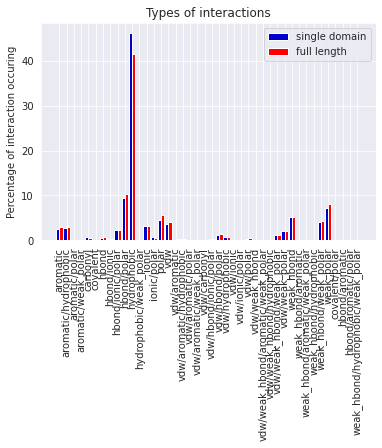

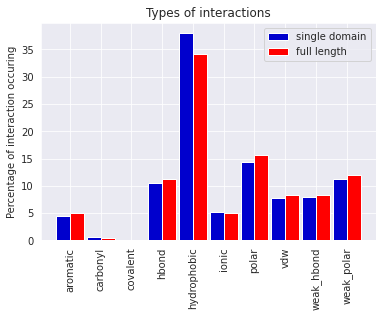

<IPython.core.display.Javascript object>

In [16]:
#compare single domain vs full length antibodies
make_hist_2db(transform_list_interactions_to_dict_occuring(dict_position_combined_interactions_nb), transform_list_interactions_to_dict_occuring(dict_position_combined_interactions_fv), "single domain", "full length", "mediumblue", "red", "Types of interactions")
make_hist_2db(transform_list_interactions_to_dict_occuring(dict_position_individual_interactions_nb), transform_list_interactions_to_dict_occuring(dict_position_individual_interactions_fv), "single domain", "full length", "mediumblue", "red", "Types of interactions")

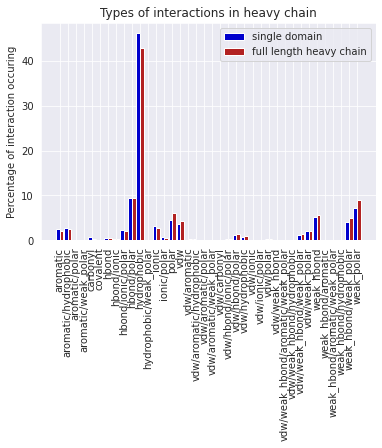

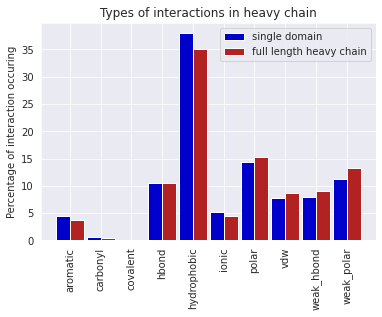

<IPython.core.display.Javascript object>

In [17]:
make_hist_2db(transform_list_interactions_to_dict_occuring(dict_position_combined_interactions_nb), transform_list_interactions_to_dict_occuring(dict_position_combined_interactions_heavy_fv), "single domain", "full length heavy chain", "mediumblue", "firebrick", "Types of interactions in heavy chain")
make_hist_2db(transform_list_interactions_to_dict_occuring(dict_position_individual_interactions_nb), transform_list_interactions_to_dict_occuring(dict_position_individual_interactions_heavy_fv), "single domain", "full length heavy chain", "mediumblue", "firebrick", "Types of interactions in heavy chain")

In [18]:
#Mutual information score between single domain antibodies and full length antibodies
list_info_numbers_nb, list_info_numbers_fv = create_input_mutual_info_score(create_list_of_all_interactions(dict_position_individual_interactions_nb), create_list_of_all_interactions(dict_position_individual_interactions_fv))
mi_score_features_nb_fv = determine_mutual_info_score(list_info_numbers_nb, list_info_numbers_fv)
print(mi_score_features_nb_fv)

0.0005685295888303572


<IPython.core.display.Javascript object>

In [19]:
#Mutual information score between single domain antibodies and full length antibodies
list_info_numbers_nb, list_info_numbers_heavy_fv = create_input_mutual_info_score(create_list_of_all_interactions(dict_position_individual_interactions_nb), create_list_of_all_interactions(dict_position_individual_interactions_heavy_fv))
mi_score_features_nb_heavyfv = determine_mutual_info_score(list_info_numbers_nb, list_info_numbers_heavy_fv)
print(mi_score_features_nb_heavyfv)

0.0005537590278534268


<IPython.core.display.Javascript object>

In [20]:
##### FRAMEWORK RESIDUES

<IPython.core.display.Javascript object>

In [21]:
#Make list of all the possible framework residues involved in the interaction
list_all_occuring_residues = set(dict_position_individual_interactions_nb.keys()) | set(dict_position_individual_interactions_fv.keys())
list_all_occuring_residues_int = []
for residue_position in list_all_occuring_residues:
    try:
        list_all_occuring_residues_int.append(int(residue_position))
    except ValueError:
        pass
list_all_possible_positions = list(range(1, max(list_all_occuring_residues_int)+1))
list_framework_residue_positions = list(set(list_all_possible_positions)-set(list_all_cdr_positions_heavy))

<IPython.core.display.Javascript object>

In [1]:
#compare single domain vs full length antibodies FRAMEWORK RESIDUES

# make_hist_2db(transform_list_interactions_to_dict_occuring(dict_position_combined_interactions_nb, list_framework_residue_positions), transform_list_interactions_to_dict_occuring(dict_position_combined_interactions_fv, list_framework_residue_positions), "single domain", "full length", "red", "mediumblue", "Interaction types of framework residues")
make_hist_2db(transform_list_interactions_to_dict_occuring(dict_position_individual_interactions_nb, list_framework_residue_positions), transform_list_interactions_to_dict_occuring(dict_position_individual_interactions_fv, list_framework_residue_positions), "sdAbs", "Abs", "royalblue", "lightcoral", "Interaction types of framework residues")

# make_hist_2db(transform_list_interactions_to_dict_occuring(dict_position_combined_interactions_nb, list_framework_residue_positions), transform_list_interactions_to_dict_occuring(dict_position_combined_interactions_heavy_fv, list_framework_residue_positions), "single domain", "full length heavy chain", "red", "darkblue", "Interaction types of framework residues in heavy chain")
make_hist_2db(transform_list_interactions_to_dict_occuring(dict_position_individual_interactions_nb, list_framework_residue_positions), transform_list_interactions_to_dict_occuring(dict_position_individual_interactions_heavy_fv, list_framework_residue_positions), "single domain", "full length heavy chain", "mediumblue", "firebrick", "Interaction types of framework residues in heavy chain")
#Note: heavy chain only plots are most important here

NameError: name 'make_hist_2db' is not defined

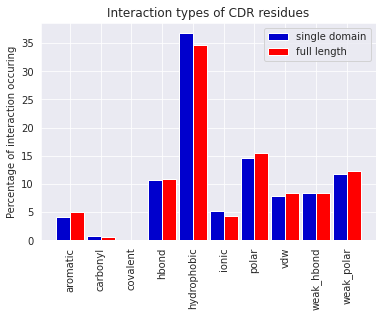

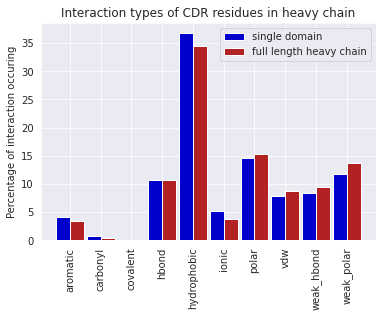

<IPython.core.display.Javascript object>

In [23]:
#compare single domain vs full length antibodies: CDR residues
# make_hist_2db(transform_list_interactions_to_dict_occuring(dict_position_combined_interactions_nb, list_all_cdr_positions_heavy), transform_list_interactions_to_dict_occuring(dict_position_combined_interactions_fv, list_all_cdr_positions_heavy), "single domain", "full length", "red", "mediumblue", "Interaction types of CDR residues")
make_hist_2db(transform_list_interactions_to_dict_occuring(dict_position_individual_interactions_nb, list_all_cdr_positions_heavy), transform_list_interactions_to_dict_occuring(dict_position_individual_interactions_fv, list_all_cdr_positions_heavy), "sdAbs", "Abs", "royalblue", "lightcoral", "Interaction types of CDR residues")

# make_hist_2db(transform_list_interactions_to_dict_occuring(dict_position_combined_interactions_nb, list_all_cdr_positions_heavy), transform_list_interactions_to_dict_occuring(dict_position_combined_interactions_heavy_fv, list_all_cdr_positions_heavy), "single domain", "full length heavy chain", "red", "darkblue", "Interaction types of CDR residues in heavy chain")
make_hist_2db(transform_list_interactions_to_dict_occuring(dict_position_individual_interactions_nb, list_all_cdr_positions_heavy), transform_list_interactions_to_dict_occuring(dict_position_individual_interactions_heavy_fv, list_all_cdr_positions_heavy), "single domain", "full length heavy chain", "mediumblue", "firebrick", "Interaction types of CDR residues in heavy chain")
#Note: heavy chain only plots are most important here

In [24]:
#nb, fl, flheavy visualised in one figure for both framework and residues. Make one order of the interaction types

<IPython.core.display.Javascript object>

              sdAbs    flAbs  flAbs heavy chain
aromatic      848.0   3213.0              131.0
carbonyl      145.0    329.0               15.0
covalent        1.0      NaN                NaN
hbond        2166.0   6911.0              408.0
hydrophobic  7490.0  21902.0             1326.0
ionic        1050.0   2726.0              142.0
polar        2964.0   9729.0              591.0
vdw          1610.0   5256.0              339.0
weak_hbond   1695.0   5301.0              363.0
weak_polar   2416.0   7760.0              529.0


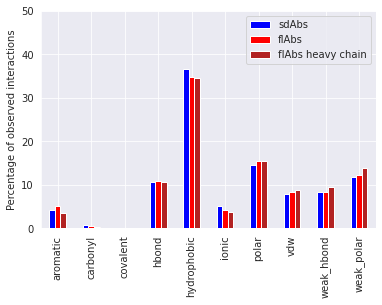

              sdAbs   flAbs  flAbs heavy chain
aromatic      255.0   366.0               34.0
carbonyl       13.0    21.0                NaN
hbond         495.0  1215.0               52.0
hydrophobic  2094.0  2854.0              221.0
ionic         260.0   880.0               51.0
polar         653.0  1629.0               80.0
vdw           346.0   724.0               40.0
weak_hbond    316.0   688.0               34.0
weak_polar    413.0   914.0               53.0
covalent        NaN     1.0                NaN


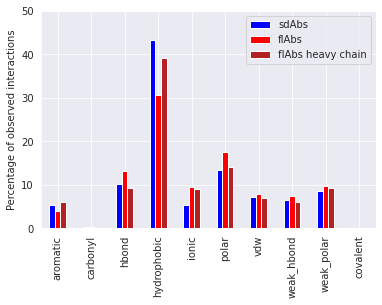

<IPython.core.display.Javascript object>

In [25]:
#CDR
make_hist_3db(transform_list_interactions_to_dict_occuring(dict_position_individual_interactions_nb, list_all_cdr_positions_heavy), transform_list_interactions_to_dict_occuring(dict_position_individual_interactions_fv, list_all_cdr_positions_heavy), transform_list_interactions_to_dict_occuring(dict_position_individual_interactions_heavy_fv, list_all_cdr_positions_heavy), ["sdAbs", "flAbs", "flAbs heavy chain"], ["blue", "red", "firebrick"], "CDR")

#Framework
make_hist_3db(transform_list_interactions_to_dict_occuring(dict_position_individual_interactions_nb, list_framework_residue_positions), transform_list_interactions_to_dict_occuring(dict_position_individual_interactions_fv, list_framework_residue_positions), transform_list_interactions_to_dict_occuring(dict_position_individual_interactions_heavy_fv, list_framework_residue_positions), ["sdAbs", "flAbs", "flAbs heavy chain"], ["blue", "red", "firebrick"], "Framework")
              
              

In [39]:
def get_total_list(col1, col2):

    total_list = dict()
    for row1, row2 in zip(col1, col2):
        total_list[row1] = row2

    return total_list

In [44]:
total_list_cdr_sdabs = get_total_list(cdr_ints_totals['Interaction type'], cdr_ints_totals['sdAbs'])
total_list_cdr_abs = get_total_list(cdr_ints_totals['Interaction type'], cdr_ints_totals['Abs'])
total_list_cdr_abs_vh = get_total_list(cdr_ints_totals['Interaction type'], cdr_ints_totals['Abs VH'])

In [47]:
total_list_fwr_sdabs = get_total_list(fwr_ints_totals['Interaction type'], fwr_ints_totals['sdAbs'])
total_list_fwr_abs = get_total_list(fwr_ints_totals['Interaction type'], fwr_ints_totals['Abs'])
total_list_fwr_abs_vh = get_total_list(fwr_ints_totals['Interaction type'], fwr_ints_totals['Abs VH'])

In [28]:
def make_hist_3db_2(df_info, ab_types: list, colors: list, title: str):
    #Makes histogram to compare the information of two different datasets
    width = 1
    
    # dict_info_1 = {key: value for key, value in sorted(dict_info_1.items())}
    # df_info = pd.DataFrame([dict_info_1, dict_info_2, dict_info_3]).T
    # df_info.columns = ab_types
    # df_info = df_info.dropna(how='all')
    # print(df_info)
    
    #Make percentages
    for ab_type in ab_types:
        df_info[ab_type] = (df_info[ab_type] / df_info[ab_type].sum()) * 100
    
    color_dict = {}
    for i in range(len(ab_types)):
        color_dict[ab_types[i]] =  colors[i]
        
    ax = df_info.plot.bar(rot=0, color=color_dict)
    
    ax.set_ylim([0, 50])
    plt.ylabel("Normalised frequency")
    plt.ylabel("Interaction type")
    plt.xticks(rotation=45)
    plt.legend()
    plt.title(f"{title}")
    plt.show()

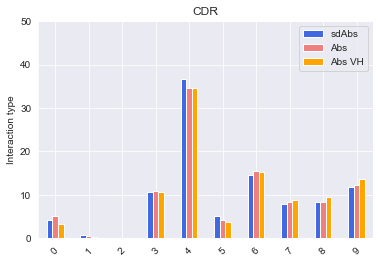

In [31]:
make_hist_3db_2(cdr_ints_totals, ["sdAbs", "Abs", "Abs VH"], ["royalblue", "lightcoral", "orange"], "CDR")

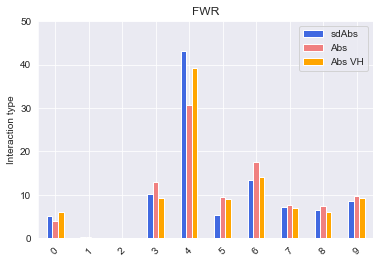

In [37]:
make_hist_3db_2(fwr_ints_totals, ["sdAbs", "Abs", "Abs VH"], ["royalblue", "lightcoral", "orange"], "FWR")

In [26]:
#Adding error bars on above plot by subsampling: 10% 1000 times

<IPython.core.display.Javascript object>

In [51]:
#Collect data 
#CDR
subsampled_cdr_sdabs = subsample_interactions(total_list_cdr_sdabs, list_all_cdr_positions_heavy, subsample= True)
subsampled_cdr_abs = subsample_interactions(total_list_cdr_abs, list_all_cdr_positions_heavy, subsample= True)
subsampled_cdr_abs_vh = subsample_interactions(total_list_cdr_abs_vh, list_all_cdr_positions_heavy, subsample= True)
#framework
# subsampled_info_frame_nb = transform_list_interactions_to_dict_occuring(dict_position_individual_interactions_nb, list_framework_residue_positions, subsample= True)
# subsampled_info_frame_fv = transform_list_interactions_to_dict_occuring(dict_position_individual_interactions_fv, list_framework_residue_positions, subsample= True)
# subsampled_info_frame_fv_heavy = transform_list_interactions_to_dict_occuring(dict_position_individual_interactions_heavy_fv, list_framework_residue_positions, subsample= True)

TypeError: Population must be a sequence or set.  For dicts, use list(d).

In [27]:
#Collect data 
#CDR
subsampled_info_cdr_nb = transform_list_interactions_to_dict_occuring(dict_position_individual_interactions_nb, list_all_cdr_positions_heavy, subsample= True)
subsampled_info_cdr_fv = transform_list_interactions_to_dict_occuring(dict_position_individual_interactions_fv, list_all_cdr_positions_heavy, subsample= True)
subsampled_info_cdr_fv_heavy = transform_list_interactions_to_dict_occuring(dict_position_individual_interactions_heavy_fv, list_all_cdr_positions_heavy, subsample= True)

#framework
subsampled_info_frame_nb = transform_list_interactions_to_dict_occuring(dict_position_individual_interactions_nb, list_framework_residue_positions, subsample= True)
subsampled_info_frame_fv = transform_list_interactions_to_dict_occuring(dict_position_individual_interactions_fv, list_framework_residue_positions, subsample= True)
subsampled_info_frame_fv_heavy = transform_list_interactions_to_dict_occuring(dict_position_individual_interactions_heavy_fv, list_framework_residue_positions, subsample= True)


<IPython.core.display.Javascript object>

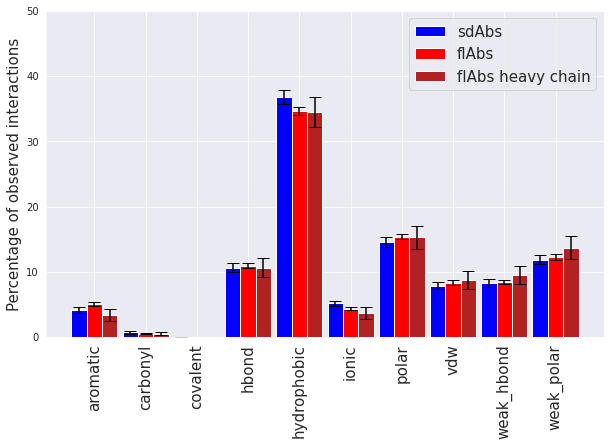

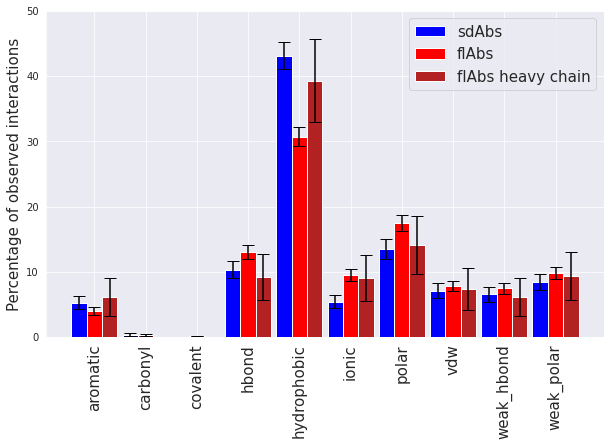

<IPython.core.display.Javascript object>

In [28]:
#plot subsampled result
make_hist_3db_subsample(subsampled_info_cdr_nb, subsampled_info_cdr_fv, subsampled_info_cdr_fv_heavy, ["sdAbs", "flAbs", "flAbs heavy chain"], ["blue", "red", "firebrick"], "CDR")

make_hist_3db_subsample(subsampled_info_frame_nb, subsampled_info_frame_fv, subsampled_info_frame_fv_heavy, ["sdAbs", "flAbs", "flAbs heavy chain"], ["blue", "red", "firebrick"], "Framework")

In [29]:
#Make boxplot

<IPython.core.display.Javascript object>

In [30]:
### Box plot. 
#All data
df_info_boxplot_all_nb = create_dataframe_boxplot_one_ds(dict_complex_info_nb, "sdAb", list_interested_positions=False)
df_info_boxplot_all_fv = create_dataframe_boxplot_one_ds(dict_complex_info_fv, "flAb", list_interested_positions=False)
df_info_boxplot_all_heavy_fv = create_dataframe_boxplot_one_ds(dict_complex_info_heavy_fv, "flAb_heavy", list_interested_positions=False)
df_info_boxplot_all = pd.concat([df_info_boxplot_all_nb, df_info_boxplot_all_fv, df_info_boxplot_all_heavy_fv]) 
df_info_boxplot_all.reset_index(inplace = True)

#Framework residues
df_info_boxplot_frame_nb = create_dataframe_boxplot_one_ds(dict_complex_info_nb, "sdAb", list_interested_positions=list_framework_residue_positions)
df_info_boxplot_frame_fv = create_dataframe_boxplot_one_ds(dict_complex_info_fv, "flAb", list_interested_positions=list_framework_residue_positions)
df_info_boxplot_frame_heavy_fv = create_dataframe_boxplot_one_ds(dict_complex_info_heavy_fv, "flAb_heavy", list_interested_positions=list_framework_residue_positions)
df_info_boxplot_frame = pd.concat([df_info_boxplot_frame_nb, df_info_boxplot_frame_fv, df_info_boxplot_frame_heavy_fv]) 
df_info_boxplot_frame.reset_index(inplace = True)

#cdr residues
df_info_boxplot_cdr_nb = create_dataframe_boxplot_one_ds(dict_complex_info_nb, "sdAb", list_interested_positions=list_all_cdr_positions_heavy)
df_info_boxplot_cdr_fv = create_dataframe_boxplot_one_ds(dict_complex_info_fv, "flAb", list_interested_positions=list_all_cdr_positions_heavy)
df_info_boxplot_cdr_heavy_fv = create_dataframe_boxplot_one_ds(dict_complex_info_heavy_fv, "flAb_heavy", list_interested_positions=list_all_cdr_positions_heavy)
df_info_boxplot_cdr = pd.concat([df_info_boxplot_cdr_nb, df_info_boxplot_cdr_fv, df_info_boxplot_cdr_heavy_fv]) 
df_info_boxplot_cdr.reset_index(inplace = True)


<IPython.core.display.Javascript object>

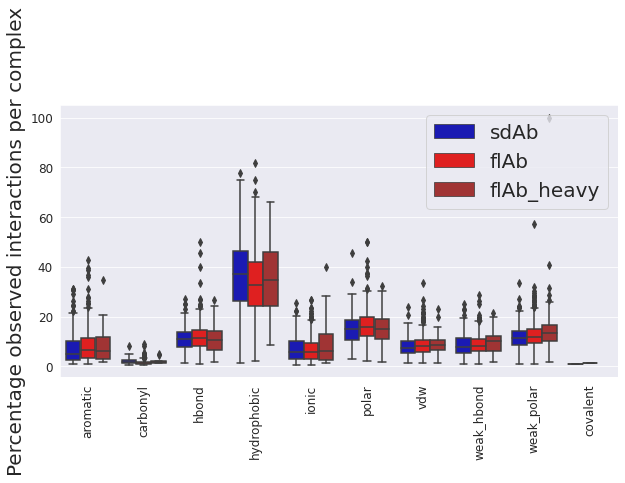

<IPython.core.display.Javascript object>

In [31]:
make_boxplot(df_info_boxplot_all)

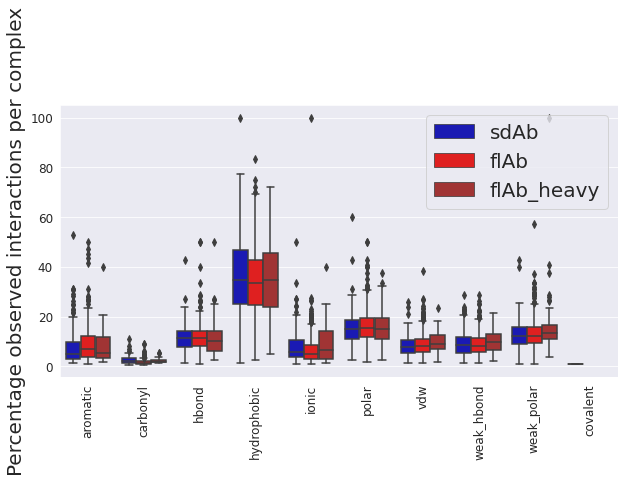

<IPython.core.display.Javascript object>

In [32]:
make_boxplot(df_info_boxplot_cdr, "cdr")

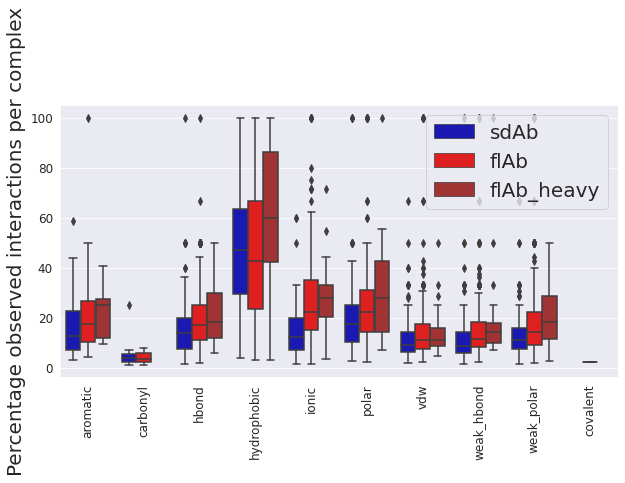

<IPython.core.display.Javascript object>

In [33]:
make_boxplot(df_info_boxplot_frame, "framework")

In [34]:
###Study the specific framework residues

<IPython.core.display.Javascript object>

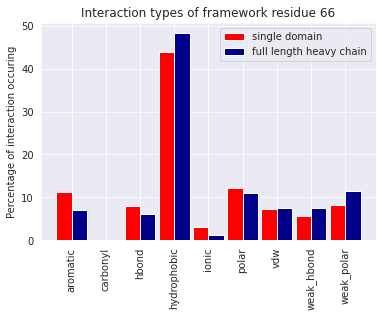

<IPython.core.display.Javascript object>

In [35]:
#Framework residue: 66 (paratope residue for approximately 50% of both sdAbs as flAbs)
#compare single domain vs full length heavy chain only
res_num = 66
make_hist_2db(transform_list_interactions_to_dict_occuring(dict_position_individual_interactions_nb, [res_num]), transform_list_interactions_to_dict_occuring(dict_position_individual_interactions_heavy_fv, [res_num]), "single domain", "full length heavy chain", "red", "darkblue", f"Interaction types of framework residue {res_num}")


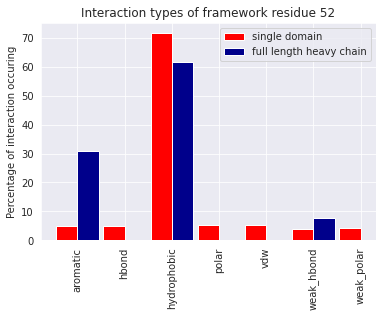

<IPython.core.display.Javascript object>

In [36]:
#Framework residue: 52 
#compare single domain vs full length heavy chain only
res_num = 52
make_hist_2db(transform_list_interactions_to_dict_occuring(dict_position_individual_interactions_nb, [res_num]), transform_list_interactions_to_dict_occuring(dict_position_individual_interactions_heavy_fv, [res_num]), "single domain", "full length heavy chain", "red", "darkblue", f"Interaction types of framework residue {res_num}")

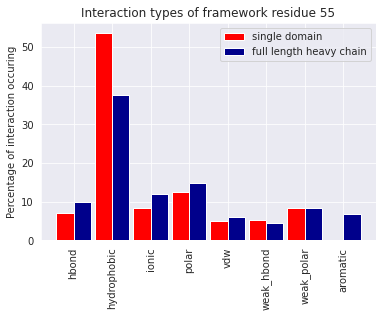

<IPython.core.display.Javascript object>

In [37]:
#Framework residue: 55 
#compare single domain vs full length heavy chain only
res_num = 55
make_hist_2db(transform_list_interactions_to_dict_occuring(dict_position_individual_interactions_nb, [res_num]), transform_list_interactions_to_dict_occuring(dict_position_individual_interactions_heavy_fv, [res_num]), "single domain", "full length heavy chain", "red", "darkblue", f"Interaction types of framework residue {res_num}")

/tmp/ipykernel_3178793/943107034.py:382: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  rects2 = ax.bar(xnames2, yvalues2_norm, +width, align='edge', color = color2, label = ab_type2)


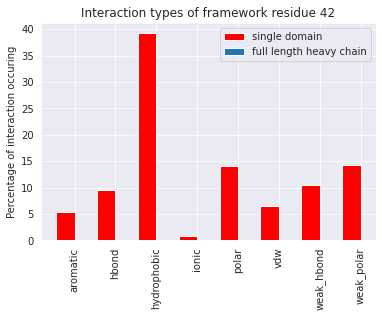

<IPython.core.display.Javascript object>

In [38]:
#Framework residue: 42 
#compare single domain vs full length heavy chain only
res_num = 42
make_hist_2db(transform_list_interactions_to_dict_occuring(dict_position_individual_interactions_nb, [res_num]), transform_list_interactions_to_dict_occuring(dict_position_individual_interactions_heavy_fv, [res_num]), "single domain", "full length heavy chain", "red", "darkblue", f"Interaction types of framework residue {res_num}")


/tmp/ipykernel_3178793/943107034.py:382: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  rects2 = ax.bar(xnames2, yvalues2_norm, +width, align='edge', color = color2, label = ab_type2)


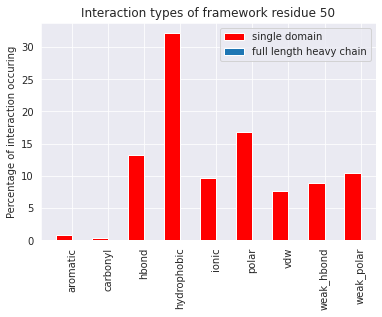

<IPython.core.display.Javascript object>

In [39]:
#Framework residue: 50 
#compare single domain vs full length heavy chain only
res_num = 50
make_hist_2db(transform_list_interactions_to_dict_occuring(dict_position_individual_interactions_nb, [res_num]), transform_list_interactions_to_dict_occuring(dict_position_individual_interactions_heavy_fv, [res_num]), "single domain", "full length heavy chain", "red", "darkblue", f"Interaction types of framework residue {res_num}")

/tmp/ipykernel_3178793/943107034.py:382: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  rects2 = ax.bar(xnames2, yvalues2_norm, +width, align='edge', color = color2, label = ab_type2)


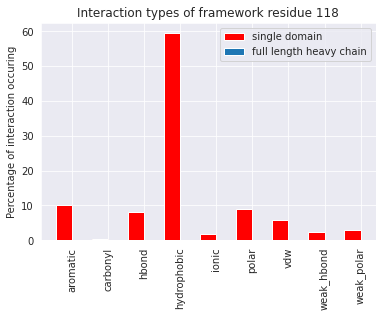

<IPython.core.display.Javascript object>

In [40]:
#Framework residue: 118 
#compare single domain vs full length heavy chain only
res_num = 118
make_hist_2db(transform_list_interactions_to_dict_occuring(dict_position_individual_interactions_nb, [res_num]), transform_list_interactions_to_dict_occuring(dict_position_individual_interactions_heavy_fv, [res_num]), "single domain", "full length heavy chain", "red", "darkblue", f"Interaction types of framework residue {res_num}")

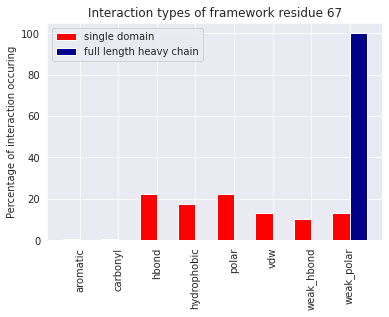

<IPython.core.display.Javascript object>

In [41]:
#Framework residue: 67 
#compare single domain vs full length heavy chain only
res_num = 67
make_hist_2db(transform_list_interactions_to_dict_occuring(dict_position_individual_interactions_nb, [res_num]), transform_list_interactions_to_dict_occuring(dict_position_individual_interactions_heavy_fv, [res_num]), "single domain", "full length heavy chain", "red", "darkblue", f"Interaction types of framework residue {res_num}")

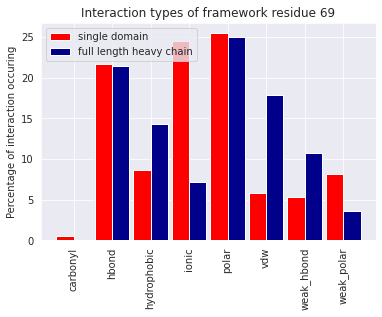

<IPython.core.display.Javascript object>

In [42]:
#Framework residue: 69 
#compare single domain vs full length heavy chain only
res_num = 69
make_hist_2db(transform_list_interactions_to_dict_occuring(dict_position_individual_interactions_nb, [res_num]), transform_list_interactions_to_dict_occuring(dict_position_individual_interactions_heavy_fv, [res_num]), "single domain", "full length heavy chain", "red", "darkblue", f"Interaction types of framework residue {res_num}")

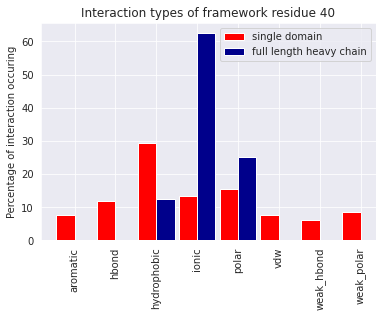

<IPython.core.display.Javascript object>

In [43]:
#Framework residue: 40 
#compare single domain vs full length heavy chain only
res_num = 40
make_hist_2db(transform_list_interactions_to_dict_occuring(dict_position_individual_interactions_nb, [res_num]), transform_list_interactions_to_dict_occuring(dict_position_individual_interactions_heavy_fv, [res_num]), "single domain", "full length heavy chain", "red", "darkblue", f"Interaction types of framework residue {res_num}")



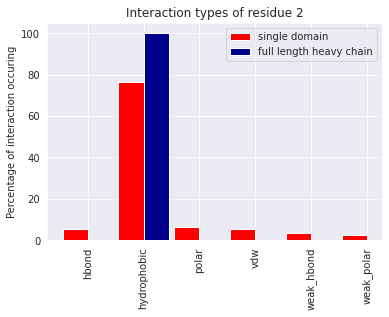

<IPython.core.display.Javascript object>

In [44]:
#residue 
#compare single domain vs full length heavy chain only
res_num = 2
make_hist_2db(transform_list_interactions_to_dict_occuring(dict_position_individual_interactions_nb, [res_num]), transform_list_interactions_to_dict_occuring(dict_position_individual_interactions_heavy_fv, [res_num]), "single domain", "full length heavy chain", "red", "darkblue", f"Interaction types of residue {res_num}")

In [45]:
### CLUSTER
#Determine for every complex which interactions are established and calculate the fraction per complex. 

<IPython.core.display.Javascript object>

In [46]:
df_occurence_interaction_per_complex_nb = create_input_for_cluster(df_nb, residue_columns_list, general_types_list, feature_list, heavy_chain_only=False)

<IPython.core.display.Javascript object>

In [47]:
df_occurence_interaction_per_complex_fv = create_input_for_cluster(df_fv, residue_columns_list, general_types_list, feature_list, heavy_chain_only=False)

File not found: 5k9q_R_XY
File not found: 4xwo_N_QR


<IPython.core.display.Javascript object>

/data/icarus/capel/miniconda3/envs/minor_internship/lib/python3.10/site-packages/seaborn/matrix.py:659: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


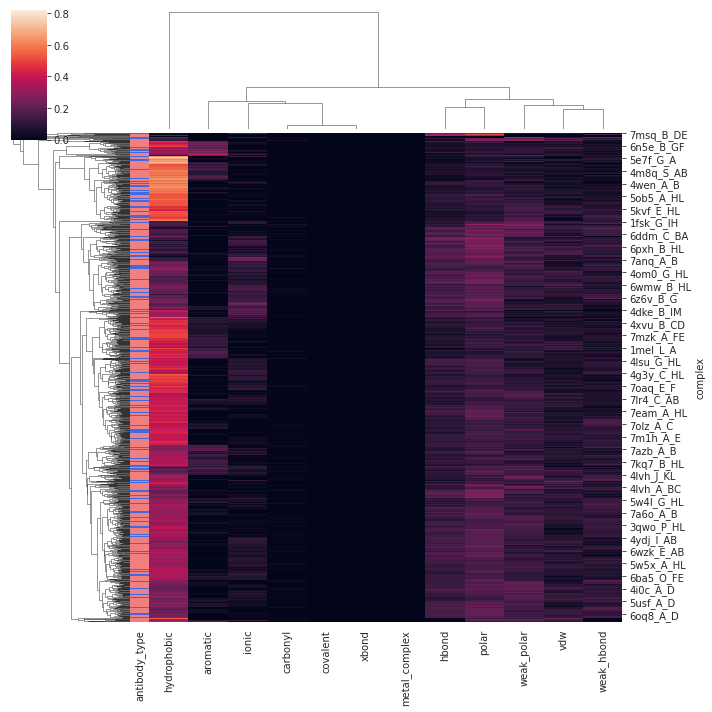

<IPython.core.display.Javascript object>

In [48]:
#Make cluster. 
df_occ_inter_per_complex_nb_fv = df_clustermap_twotypes_info(df_occurence_interaction_per_complex_nb, df_occurence_interaction_per_complex_fv)
plot_cluster(df_occ_inter_per_complex_nb_fv, two_types = True)

In [49]:
######Study the type of interactions per amino acid type:
#For every complex: determine which residues in the epitope have a certain amino acid. Run "determine_feature_interactions" on this complex, and only consider the epitope residues selected.

<IPython.core.display.Javascript object>

In [50]:
#Single domain antibodies
df_arp_formatted_nb = read_dataset("Dataset_nb_arpeggio_interactions.csv") 

<IPython.core.display.Javascript object>

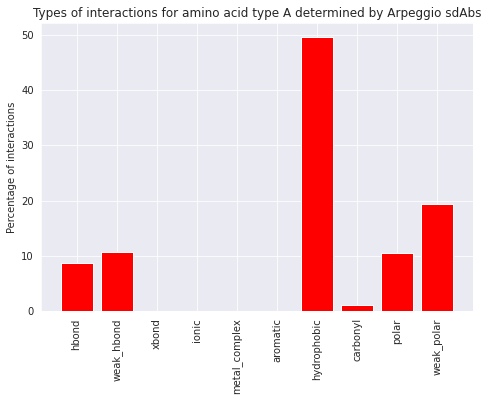

<IPython.core.display.Javascript object>

In [51]:
#Study residue type A
aa_type = "A"
dict_int_per_aa_type = determine_type_interactions_per_aa_type(df_arp_formatted_nb, aa_type, residue_columns_list, general_types_list, feature_list, "antigen")
make_histogram(dict_int_per_aa_type, f"Types of interactions for amino acid type {aa_type} determined by Arpeggio sdAbs", "red")

In [52]:
#Full length antibody
df_arp_formatted_fv = read_dataset("Dataset_fv_arpeggio_interactions.csv") 

<IPython.core.display.Javascript object>

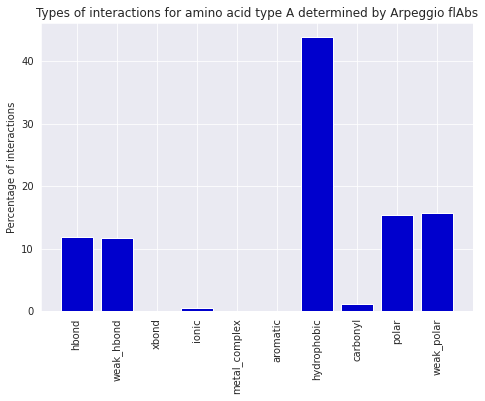

<IPython.core.display.Javascript object>

In [53]:
aa_type = "A"
dict_int_per_aa_type = determine_type_interactions_per_aa_type(df_arp_formatted_fv, aa_type, residue_columns_list, general_types_list, feature_list, "antigen", False)
make_histogram(dict_int_per_aa_type, f"Types of interactions for amino acid type {aa_type} determined by Arpeggio flAbs", "mediumblue")